#  Workflow

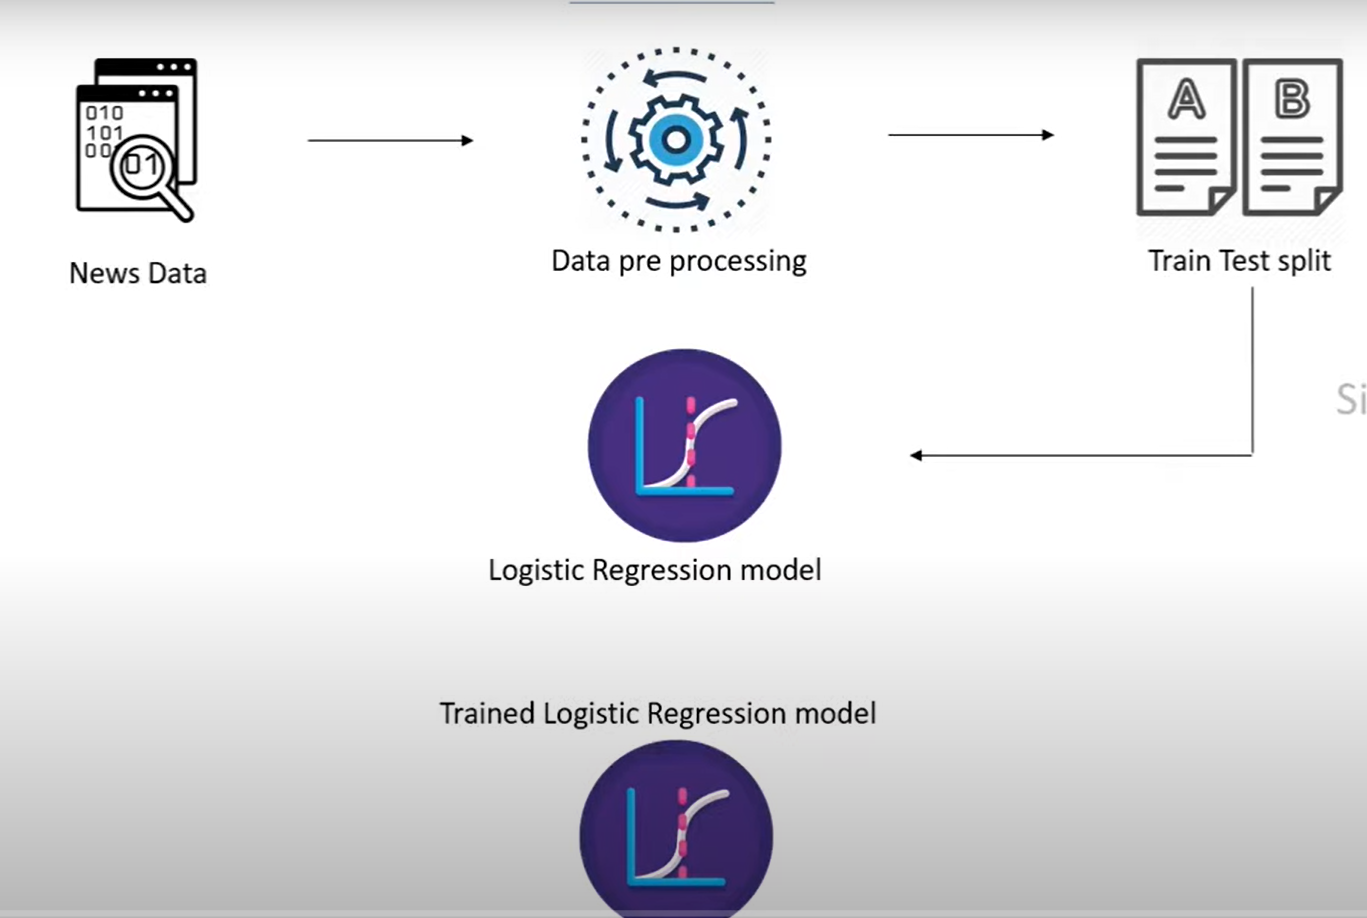

#  Importing dependencies

In [94]:
import numpy as np
import pandas as pd

#Regular expression (regex), used for search patterns in strings
import re

#For natural language processing
#Removes stopwords like (if, and, the, is) giving us more valuable data
from nltk.corpus import stopwords

#Stems words to its base form to optimize data
#Example: Running, Runner, Ran --> Run
from nltk.stem.porter import PorterStemmer

#Convert the text to feature vectors, based on TF-IDF
#Numeric statistic that reports how important a word is 
from sklearn.feature_extraction.text import TfidfVectorizer

#Randomly splits data into training and testing sets
from sklearn.model_selection import train_test_split

#Logistic Regression model used because of our binary classification task
#Model returns either (True or False) to isFakeNews?
from sklearn.linear_model import LogisticRegression

#calculates the accuracy of the classification model
from sklearn.metrics import accuracy_score

#Plots training accuracy improvement
import matplotlib.pyplot as plt

#Used to save our model:
import joblib

In [7]:
#Downloads all the stopwords (Words with little value)
#Example (And, if, is, etc...)
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\13054\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
#Run this line to see the first ten stopwords
print(stopwords.words('english')[0:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


#  Data Pre Processing

In [23]:
#loading the dataset through pandas dataframe
news_dataset = pd.read_csv('train.csv')

In [25]:
#20800 Rows (input data)
#5 Columns (features)
print(news_dataset.shape)

(20800, 5)


In [26]:
#first five elements in data
news_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [28]:
#Finding missing values and counting them in the dataset
news_dataset.isnull().sum()

#Author and title have most missing values
#Since we have 20800 values we decided to drop them instead of replacing them. 
#we'll be left with approximatly 18800 values which is sufficient

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [29]:
#Replacing missing values with empty string
news_dataset = news_dataset.fillna('')

In [30]:
#result after running fillna()
#each row and column now has data in it
news_dataset.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

#  Important decision (Read)

We've decided to use title and author to predict the legitimacy of our data

Using the text requires an extreme amount of processing power

However we considered using approaches like: TF-IDF to summarize the text and extract features

Applying Principal Component Analysis (PCA) to reduce dimensionality

Random or specific text cropping, and word tokenizing

All these approaches would have drastically shrank the text size while still keeping the most important features

However we realized that using the titles and authors gave us better results

An argument could be made that training the model on text would have yielded better results, Especially for training our data.
If we decided to train it more we would see improvements through each Epoch. Our model is too simple to be optimized. 

However for a 3 day project, using title and author gave us a very desirable result, with no hard computations

In [36]:
#merging author and title data
news_dataset['content'] = news_dataset['author'] + ' ' + news_dataset['title']

news_dataset['content'].head()

0    Darrell Lucus House Dem Aide: We Didn’t Even S...
1    Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2    Consortiumnews.com Why the Truth Might Get You...
3    Jessica Purkiss 15 Civilians Killed In Single ...
4    Howard Portnoy Iranian woman jailed for fictio...
Name: content, dtype: object

In [48]:
# Seperate data & labels, axis = 1 removes column
X = news_dataset.drop(columns = 'label', axis = 1)

Y = news_dataset['label']

print(X.head())

print('\n--------------------------------------------------------------------')

print(Y.head())

   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1  Ever get the feeling your life circles the rou...   
2  Why the Truth Might Get You Fired October 29, ...   
3  Videos 15 Civilians Killed In Single US Airstr...   
4  Print \nAn Iranian woman has been sentenced to...   

                                             content  
0  Darrell Lucus House Dem Aide: We Didn’t Even S...  
1  Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...  
2  Consortiumnews

# Stemming

reduces word to its root word

running, ran, runner ----> run

PorterStemmer is a rule based algorithm that follows certain steps

    Remove SSES, IES, SS 
    
    Remove S (plural removal), EED or EE 
    
    Replace Y with I
    
There are 7 steps in total, and it's a very efficient algorithm 

We also considered using the Snowball stemmer, but improvements were negliable 

We do some simple operations on the text before we start the stemming process:

In [49]:
port_stem = PorterStemmer()

In [50]:
#Stemming function to optimize our data
def stemming(content):
    #replaces any character that isn'tm a lower or uppercase character with a space
    stemmed_content = re.sub('[^a-zA-z]', ' ', content)
    
    #sets all characters to lower case, optimizes data processing
    stemmed_content = stemmed_content.lower()
    
    #converts stemmed_content into an array that can be stemmed
    stemmed_content = stemmed_content.split()
    
    #stemms each word in our array
    #removes stop words
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    
    #converts stemmed_content back to a String
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

In [55]:
#Updates the dataset by applying our stemming function to our content
#This will drastically optimize our data
news_dataset['content'] = news_dataset['content'].apply(stemming)

In [56]:
news_dataset['content'].head()

0    darrel lucu hou dem aid even see comey letter ...
1    daniel j flynn flynn hillari clinton big woman...
2               consortiumnew com truth might get fire
3    jessica purkiss civilian kill singl us airstri...
4    howard portnoy iranian woman jail fiction unpu...
Name: content, dtype: object

In [71]:
#seperating the data and label

#X is all the data that got stemmed
X = news_dataset['content'].values

#Y are all the corresponding labels indicating fake or real news
Y = news_dataset['label'].values

print(X)
print(Y)
print(Y.shape)

['darrel lucu hou dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exerci balkan'
 'david swanson keep f aliv']
[1 0 1 ... 0 1 1]
(20800,)


In [72]:
# Creating an instance of the TfidfVectorizer class
vectorizer = TfidfVectorizer()

# Fitting the vectorizer on the training data X
vectorizer.fit(X)

# Transforming the textual data in X into numerical data using the fitted vectorizer
X = vectorizer.transform(X)

#TF-IDF values each term based on occurences in relation to total terms in the data
#We chose the TF-IDF algorithm based on it's simplicity and effectivness

print(X)

  (0, 15558)	0.28485063562728646
  (0, 13351)	0.2565896679337957
  (0, 8825)	0.3635963806326075
  (0, 8549)	0.29212514087043684
  (0, 7615)	0.24785219520671603
  (0, 6936)	0.21874169089359144
  (0, 4923)	0.233316966909351
  (0, 3762)	0.2705332480845492
  (0, 3570)	0.3598939188262559
  (0, 2936)	0.2468450128533713
  (0, 2466)	0.3676519686797209
  (0, 264)	0.27010124977708766
  (1, 16661)	0.3025156488372128
  (1, 6750)	0.19152496072048605
  (1, 5447)	0.7186013955384664
  (1, 3538)	0.2653147533915268
  (1, 2793)	0.19208753385709676
  (1, 2207)	0.36915639258038363
  (1, 1878)	0.15614790568229528
  (1, 1482)	0.2957471154505952
  (2, 15483)	0.41544962664721613
  (2, 9534)	0.49351492943649944
  (2, 5909)	0.3474613386728292
  (2, 5333)	0.3866530551182615
  (2, 3075)	0.46097489583229645
  :	:
  (20797, 13000)	0.2483705036831893
  (20797, 12230)	0.27276402145717243
  (20797, 12025)	0.24790022252744132
  (20797, 10218)	0.0804189541935242
  (20797, 9502)	0.17463635692029988
  (20797, 9433)	0.29394

# Splitting dataset to test and training

In [88]:
#randomly splits training and testing set
#Split into 80:20 model, stratify = Y ensures target variable is distributed equally 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, stratify = Y, random_state = 2)

#  Training the Model, Logistic Regression

In [89]:
model = LogisticRegression()

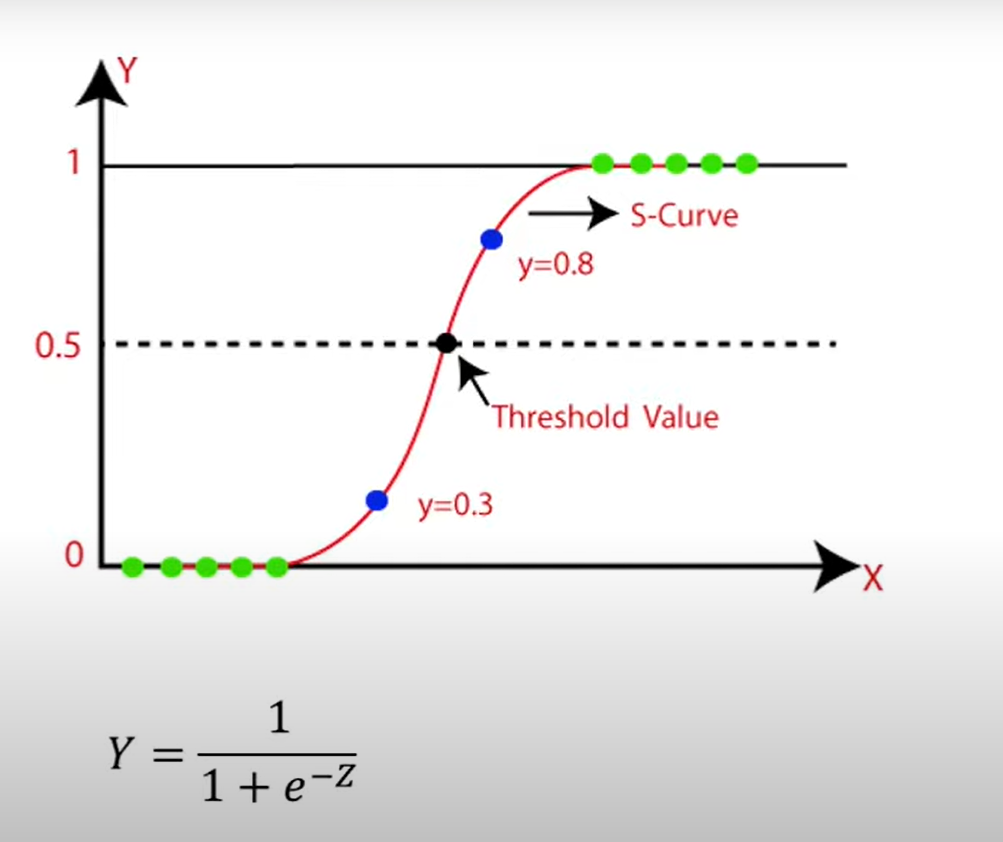 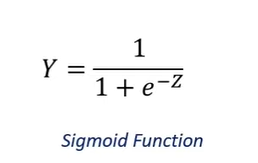

The labels are binary: Represented by either a 0 or a 1

Our logistic regression models will make predictions between 0 and 1

If the prediction = 0.5, the model is unsure. 

Y = 0.3, shows favor towards 0, while Y = 0.8 shows favor towards 1

The Simgoid function always returns a value in the range 0 to 1, and is therefore used for our binary results

There were no significant improvement over each epoch. The general accuracy was around 0.986

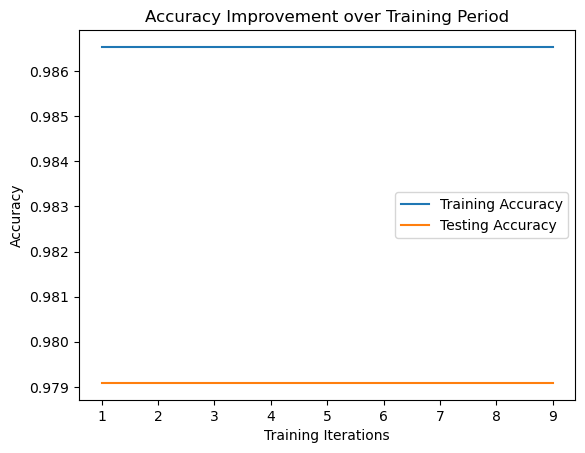

In [90]:
train_accuracy = []
test_accuracy = []

#No matter what range, the accuracy approximatly remained the same
#Training the model with epochs = 1 took a few miliseconds, but still gave a desiarable result
for i in range(1, 10):
    model.fit(X_train, Y_train)
    
    # Predictions on training and testing sets
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    
    # Calculate accuracy and append to the lists
    train_acc = accuracy_score(Y_train, Y_train_pred)
    test_acc = accuracy_score(Y_test, Y_test_pred)
    
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    
# Plotting the accuracy improvement over the training period
iterations = range(1, 10)
plt.plot(iterations, train_accuracy, label='Training Accuracy')
plt.plot(iterations, test_accuracy, label='Testing Accuracy')
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Improvement over Training Period')
plt.legend()
plt.show()

# Evaluating our model

In [85]:
#Accuracy score:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

training_data_accuracy

0.9865384615384616

# Saving & Loading our model

In [96]:
# Save the trained model to a file
joblib.dump(model, 'trained_model.joblib')

['trained_model.joblib']

In [97]:
# Load the model from the file
loaded_model = joblib.load('trained_model.joblib')

In [99]:
#Make predictions using the loaded model
Y_pred = loaded_model.predict(X_test)

#Evaluate accuracy using the loaded model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.9791
